# Chapter 4: Collecting a Displaying Records

In this chapter, our first agile sprint, we climb level 1 of the data-value pyramid (Figure 4-1). We will connect, or plumb, the parts of our data pipeline all the way through from raw data to a web application on a user’s screen. This will enable a single developer to publish raw data records on the web. In doing so, we will activate our stack against our real data, thereby connecting our application to the reality of our data and our users.

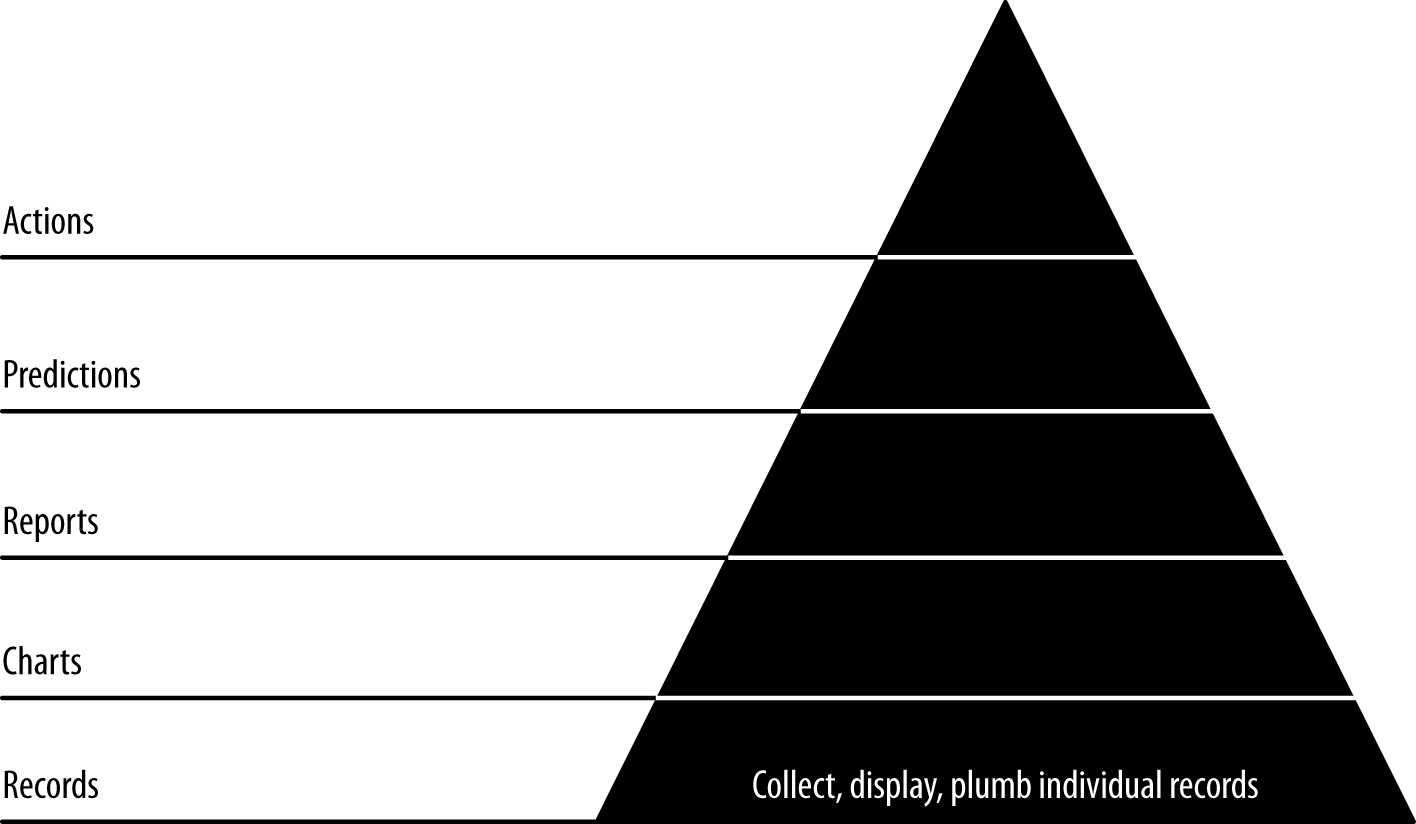

If you already have a popular application, this step may seem confusing in that you already have the individual (or atomic) records displaying in your application. The point of this step, then, is to pipe these records through your analytical pipeline to bulk storage and then on to a browser. Bulk storage provides access for further processing via ETL (extract, transform, load) or some other means.

This first stage of the data-value pyramid can proceed relatively quickly, so we can get on to higher levels of value. Note that we will return to this step frequently as we enrich our analysis with additional datasets. We’ll make each new dataset explorable as we go. We’ll be doing this throughout the book as we work through the higher-level steps. The data-value pyramid is something you step up and down in as you do your analysis and get feedback from users. This setup and these browsable records set the stage for further advances up the data-value pyramid as our complexity and value snowball.

## Putting It All Together

Setting up our stack was a bit of work. The good news is, with this stack, we don’t have to repeat this work as soon as we start to see load from users on our system increase and our stack needs to scale. Instead, we’ll be free to continue to iterate and improve our product from now on.

Now, let’s work with some atomic records—on-time records for each flight originating in the US in 2015—to see how the stack works for us.

_Note: An atomic record is a base record, the most granular of the events you will be analyzing. We might aggregate, count, slice, and dice atomic records, but they are indivisible. As such, they represent ground truth to us, and working with atomic records is essential to plugging into the reality of our data and our application. The point of big data is to be able to analyze the most granular data using NoSQL tools to reach a deeper level of understanding than was previously possible._

## Collecting and Serializing Flight Data

You can see the process of collecting and serializing events in the image below. 

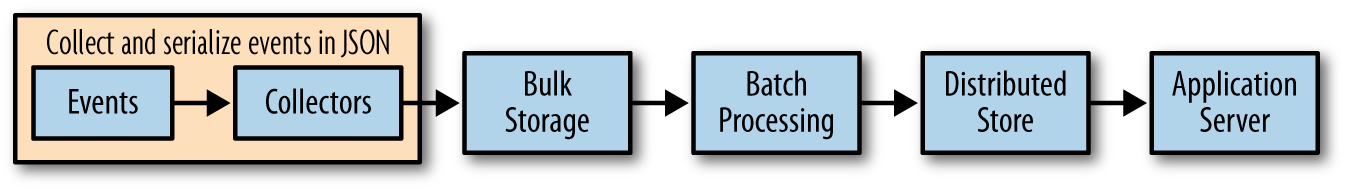

In this case, we have downloaded the core data that we’ll use for the remainder of the book using a script, [download.sh](../download.sh):

```bash
# Get on-time records for all flights in 2015 - 273MB
wget -P data/ \
 http://s3.amazonaws.com/agile_data_science/ \
  On_Time_On_Time_Performance_2015.csv.bz2

# Get openflights data
wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/airports.dat
mv /tmp/airports.dat data/airports.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/airlines.dat
mv /tmp/airlines.dat data/airlines.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/routes.dat
mv /tmp/routes.dat data/routes.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/countries.dat
mv /tmp/countries.dat data/countries.csv

# Get FAA data
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/aircraft.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/ata.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/compt.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/engine.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/prop.txt
```

This has been run before you in advance. You don't have to run it.

## Processing On-Time Flight Records

To get started, we’ll trim the unneeded fields from our on-time flight records and convert them to Parquet format. This will improve performance when loading this data, something we’ll be doing throughout the book. In practice, you would want to retain all the values that might be of interest in the future. Note that there is a bug in the inferSchema option of spark-csv, so we’ll have to cast the numeric fields manually before saving our converted data.

If you want to make sense of the following query, take a look at the Bureau of Transportation Statistics description of the data, On-Time Performance records (this data was introduced in Chapter 3).

### Initializing PySpark

Run the following code to initialize PySpark:

In [13]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


### Trimming Fields

Run the following code to trim the data to just the fields we will need:

In [24]:
# Loads CSV with header parsing and type inference, in one line!
on_time_dataframe = spark.read.csv(
    '../data/On_Time_On_Time_Performance_2015.csv.bz2', 
    header=True
)
on_time_dataframe.limit(20).toPandas().head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,_c109
0,2015,1,1,1,4,2015-01-01,AA,19805,AA,N001AA,...,None,None,None,None,None,None,None,None,None,None
1,2015,1,1,1,4,2015-01-01,AA,19805,AA,N001AA,...,None,None,None,None,None,None,None,None,None,None
2,2015,1,1,1,4,2015-01-01,AA,19805,AA,N002AA,...,None,None,None,None,None,None,None,None,None,None
3,2015,1,1,1,4,2015-01-01,AA,19805,AA,N003AA,...,None,None,None,None,None,None,None,None,None,None
4,2015,1,1,1,4,2015-01-01,AA,19805,AA,N003AA,...,None,None,None,None,None,None,None,None,None,None


In [25]:
on_time_dataframe.registerTempTable("on_time_performance")

trimmed_cast_performance = spark.sql("""
SELECT
  Year, Quarter, Month, DayofMonth, DayOfWeek, FlightDate,
  Carrier, TailNum, FlightNum,
  Origin, OriginCityName, OriginState,
  Dest, DestCityName, DestState,
  DepTime, cast(DepDelay as float), cast(DepDelayMinutes as int),
  cast(TaxiOut as float), cast(TaxiIn as float),
  WheelsOff, WheelsOn,
  ArrTime, cast(ArrDelay as float), cast(ArrDelayMinutes as float),
  cast(Cancelled as int), cast(Diverted as int),
  cast(ActualElapsedTime as float), cast(AirTime as float),
  cast(Flights as int), cast(Distance as float),
  cast(CarrierDelay as float), cast(WeatherDelay as float), 
  cast(NASDelay as float),
  cast(SecurityDelay as float), 
  cast(LateAircraftDelay as float),
  CRSDepTime, CRSArrTime
FROM
  on_time_performance
""")

# Replace on_time_performance table# with our new, trimmed table and show its contents
trimmed_cast_performance.registerTempTable("on_time_performance")
trimmed_cast_performance.limit(10).toPandas().head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Carrier,TailNum,FlightNum,Origin,...,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepTime,CRSArrTime
0,2015,1,1,1,4,2015-01-01,AA,N001AA,1519,DFW,...,59.0,1,432.0,NaN,NaN,NaN,NaN,NaN,1345,1510
1,2015,1,1,1,4,2015-01-01,AA,N001AA,1519,MEM,...,77.0,1,432.0,NaN,NaN,NaN,NaN,NaN,1550,1730
2,2015,1,1,1,4,2015-01-01,AA,N002AA,2349,ORD,...,129.0,1,802.0,0.0,0.0,26.0,0.0,0.0,1845,2115
3,2015,1,1,1,4,2015-01-01,AA,N003AA,1298,DFW,...,93.0,1,731.0,19.0,0.0,12.0,0.0,81.0,1820,2120
4,2015,1,1,1,4,2015-01-01,AA,N003AA,1422,DFW,...,111.0,1,769.0,78.0,0.0,0.0,0.0,0.0,0800,0925


A much abreviated version of this data table looks like the following:

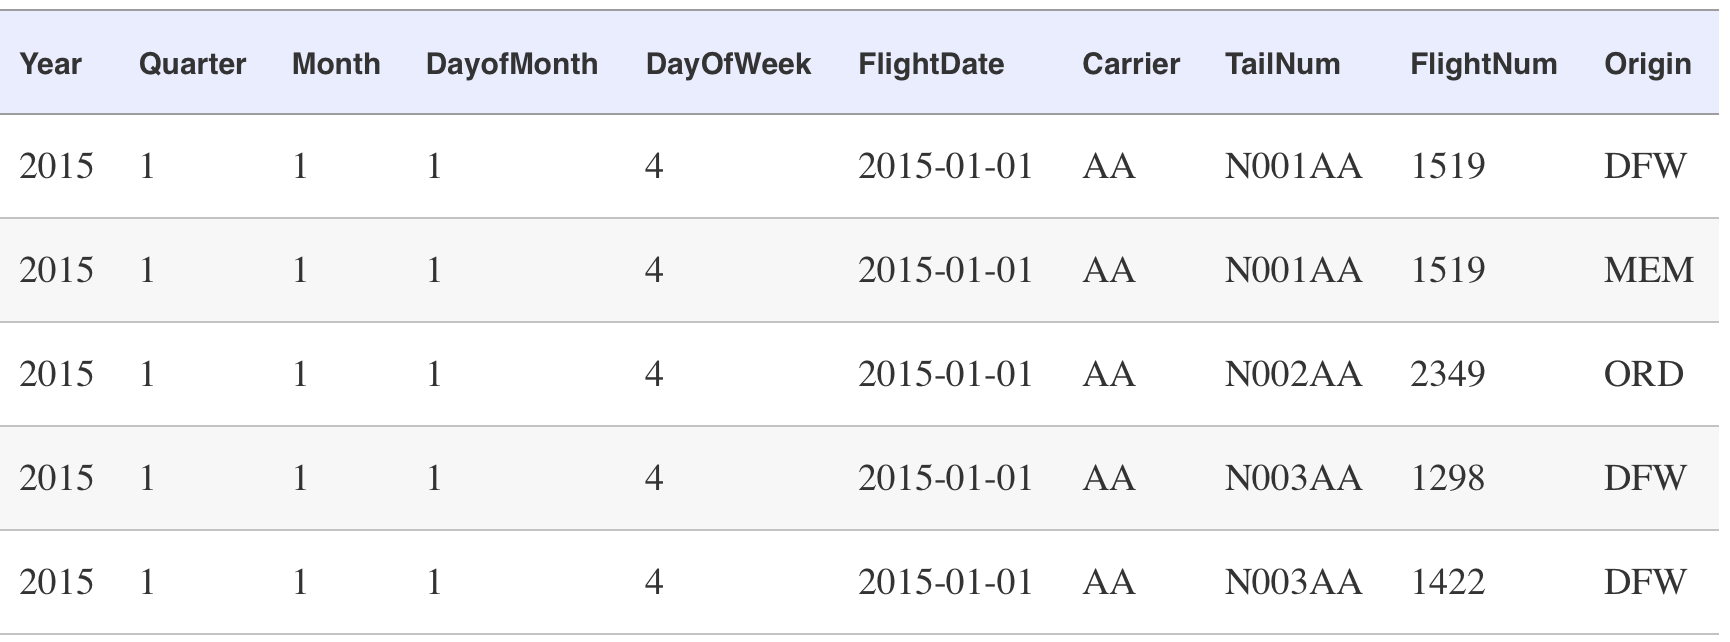


### Running a Test Query

Let’s make sure our numeric fields work as desired:

In [26]:
# Verify we can sum numeric columns
spark.sql("""SELECT
  SUM(WeatherDelay), SUM(CarrierDelay), SUM(NASDelay),
  SUM(SecurityDelay), SUM(LateAircraftDelay)
FROM on_time_performance
""").show(5)

spark.sql("""SELECT
  SUM(WeatherDelay), SUM(CarrierDelay), SUM(NASDelay),
  SUM(SecurityDelay), SUM(LateAircraftDelay)
FROM on_time_performance
""").limit(5).toPandas()

+-----------------+-----------------+-------------+------------------+----------------------+
|sum(WeatherDelay)|sum(CarrierDelay)|sum(NASDelay)|sum(SecurityDelay)|sum(LateAircraftDelay)|
+-----------------+-----------------+-------------+------------------+----------------------+
|        3100233.0|      2.0172956E7|  1.4335762E7|           80985.0|           2.4961931E7|
+-----------------+-----------------+-------------+------------------+----------------------+



,sum(WeatherDelay),sum(CarrierDelay),sum(NASDelay),sum(SecurityDelay),sum(LateAircraftDelay)
0,3100233.0,20172956.0,14335762.0,80985.0,24961931.0


### Trimming Our Data to January, 2015

Because we are running in a virtual machine, we will need to trim our data down to work with limited memory (RAM). For this reason we will trim the data from all twelve months of 2015 down to just January of 2015.

In [27]:
january_data = spark.sql("""
   SELECT * FROM on_time_performance WHERE FlightDate >= "2015-01-01" AND FlightDate <= "2015-12-31"
""")
january_data.show(3)

+----+-------+-----+----------+---------+----------+-------+-------+---------+------+--------------------+-----------+----+--------------------+---------+-------+--------+---------------+-------+------+---------+--------+-------+--------+---------------+---------+--------+-----------------+-------+-------+--------+------------+------------+--------+-------------+-----------------+----------+----------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Carrier|TailNum|FlightNum|Origin|      OriginCityName|OriginState|Dest|        DestCityName|DestState|DepTime|DepDelay|DepDelayMinutes|TaxiOut|TaxiIn|WheelsOff|WheelsOn|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|AirTime|Flights|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|CRSDepTime|CRSArrTime|
+----+-------+-----+----------+---------+----------+-------+-------+---------+------+--------------------+-----------+----+--------------------+---------+-------+--------+---------------+-

### Storing Records in Parquet Format

Now we will store the data as Parquet format, which is a columnar storage format. That means if we only load a few columns of the data, it will only load those few columns, so the data will load faster. 

Note that we also load the data back from the Parquet file, to verify that it loads correctly. Make sure this code runs without error, as the entire rest of the book uses these files:

In [32]:
# First lets save the data as Gzipped JSON
# january_data.toJSON()\
#   .saveAsTextFile(
#     '../data/on_time_performance.jsonl.gz',
#     'org.apache.hadoop.io.compress.GzipCodec'
#   )

# Load JSON records back
# on_time_dataframe = spark.read.json('../data/on_time_performance.jsonl.gz')
# on_time_dataframe.show(3)

# Save records using Parquet
january_data.write.mode('overwrite').parquet("../data/on_time_performance.parquet")

# Load the Parquet file back
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.show(3)

+----+-------+-----+----------+---------+----------+-------+-------+---------+------+--------------------+-----------+----+--------------------+---------+-------+--------+---------------+-------+------+---------+--------+-------+--------+---------------+---------+--------+-----------------+-------+-------+--------+------------+------------+--------+-------------+-----------------+----------+----------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Carrier|TailNum|FlightNum|Origin|      OriginCityName|OriginState|Dest|        DestCityName|DestState|DepTime|DepDelay|DepDelayMinutes|TaxiOut|TaxiIn|WheelsOff|WheelsOn|ArrTime|ArrDelay|ArrDelayMinutes|Cancelled|Diverted|ActualElapsedTime|AirTime|Flights|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|CRSDepTime|CRSArrTime|
+----+-------+-----+----------+---------+----------+-------+-------+---------+------+--------------------+-----------+----+--------------------+---------+-------+--------+---------------+-

### Sizing Up Our Data

Lets look at how large the datasets are: the original bzip file of CSV records, the uncompressed CSV files, and the Parquet file. We'll use `bash` to inspect the files.

In [29]:
%%bash

du -s ../data/* | sort -n

4	../data/example.csv
8	../data/countries.csv
32	../data/ata.txt
72	../data/prop.txt
104	../data/compt.txt
276	../data/engine.txt
388	../data/airlines.csv
728	../data/aircraft.txt
952	../data/faa_tail_number_inquiry.jsonl
1084	../data/airports.csv
2324	../data/routes.csv
164768	../data/on_time_performance.parquet
169336	../data/On_Time_On_Time_Performance_2015.csv.bz2


Note that the Parquet file is only 163MB MB, compared with 331 MB for the gzip-compressed JSON. That is a 50% reduction before we even load individual columns, because the columns are compressed inidividually. Individually compressed columns of data have a lot of redundancy, so they compress well. In practice the Parquet will be much more performant, as it will only load the individual columns we actually use in our PySpark scripts.

### Inspecting the Data

We can use `gunzip -c` to inspect the JSON records.

In [30]:
%%bash

gunzip -c ../data/on_time_performance.jsonl.gz/part-00000.gz | head -3

gzip: ../data/on_time_performance.jsonl.gz/part-00000.gz: No such file or directory


## Processing and Publishing Flight Records

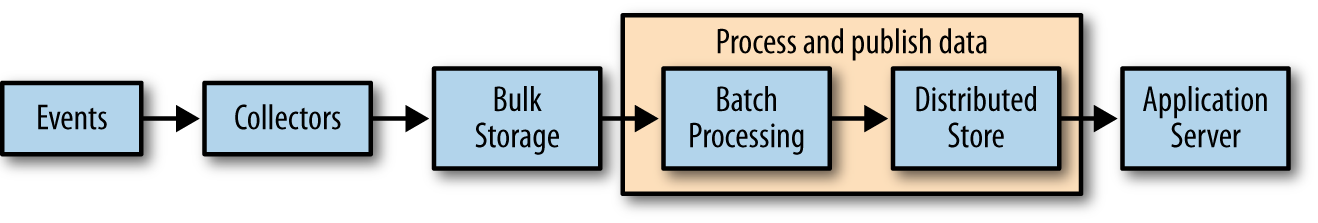

Having collected our flight data, let’s process it. In the interest of plumbing our stack all the way through with real data to give us a base state to build from, let’s publish the on-time flight records right away to MongoDB and Elasticsearch, so we can access them from the web with Mongo, Elasticsearch, and Flask.

### Publishing Flight Records to MongoDB

MongoDB’s Spark integration makes this easy. We simply need to import and activate pymongo_spark, convert our DataFrame to an RDD, and call saveToMongoDB.

In [37]:
import pymongo
import pymongo_spark
# Important: activate pymongo_spark
pymongo_spark.activate()

on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Note we have to convert the row to a dict 
# to avoid https://jira.mongodb.org/browse/HADOOP-276 and https://issues.apache.org/jira/browse/SPARK-14229
as_dict = on_time_dataframe.rdd.map(lambda row: row.asDict())
as_dict.saveToMongoDB('mongodb://localhost:27017/agile_data_science.on_time_performance')

print("Data saved to MongoDB!")

Data saved to MongoDB!


### Starting Over

If something goes wrong so that the data is only partially stored, you can remove the entire collection from MongoDB with the Mongo shell. In this case we won't test it out, because storing all the on-time flight records for January to MongoDB takes a while.

In `bash`, run:

```bash
mongo agile_data_science
```

Now run:

```javascript
db.on_time_performance.drop()
```

The beauty of our infrastructure is that everything is reproducible from the original data, so there is little worrying to be done about our database becoming corrupted or crashing (although we do employ a fault-tolerant cluster). In addition, because we’re using our database as a document store, where we simply fetch documents by some ID or field, we don’t have to worry much about performance, either.

### Verifying our Record in MongoDB

Let’s use the Terminal we used earlier to verify that our flight records are in MongoDB. Run:

```bash
mongo agile_data_science
```

Now in the Mongo console, run:

```javascript
db.on_time_performance.findOne()
```

You should see something like the following:

```json
{
	"_id" : ObjectId("5ae55c95ca56c66be1d69c30"),
	"Origin" : "SMF",
	"FlightNum" : "269",
	"Quarter" : "3",
	"LateAircraftDelay" : null,
	"NASDelay" : null,
	"ArrTime" : "1046",
	"DestState" : "TX",
	"AirTime" : 175,
	"DepTime" : "0521",
	"Month" : "7",
	"Flights" : 1,
	"Carrier" : "AA",
	"DayofMonth" : "14",
	"Distance" : 1431,
	"CRSDepTime" : "0520",
	"SecurityDelay" : null,
	"DayOfWeek" : "2",
	"Dest" : "DFW",
	"DepDelayMinutes" : 1,
	"WheelsOff" : "0531",
	"TaxiIn" : 20,
	"DepDelay" : 1,
	"Diverted" : 0,
	"Cancelled" : 0,
	"ArrDelay" : 2,
	"TaxiOut" : 10,
	"ActualElapsedTime" : 205,
	"CarrierDelay" : null,
	"FlightDate" : "2015-07-14",
	"OriginCityName" : "Sacramento, CA",
	"Year" : "2015",
	"OriginState" : "CA",
	"WeatherDelay" : null,
	"CRSArrTime" : "1044",
	"ArrDelayMinutes" : 2,
	"TailNum" : "N488AA",
	"WheelsOn" : "1026",
	"DestCityName" : "Dallas/Fort Worth, TX"
}
```

### Fetching Records By Field

Now let’s fetch one flight record, using its minimum unique identifiers—the airline carrier, the flight date, and the flight number:

```javascript
db.on_time_performance.findOne({Carrier: 'DL', FlightDate: '2015-01-01', FlightNum: '478'})
```

```json
{
	"_id" : ObjectId("5ae55c9dca56c66be1d78c03"),
	"Origin" : "ATL",
	"FlightNum" : "478",
	"Quarter" : "1",
	"LateAircraftDelay" : null,
	"NASDelay" : null,
	"ArrTime" : "1842",
	"DestState" : "NY",
	"AirTime" : 106,
	"DepTime" : "1623",
	"Month" : "1",
	"Flights" : 1,
	"Carrier" : "DL",
	"DayofMonth" : "1",
	"Distance" : 760,
	"CRSDepTime" : "1615",
	"SecurityDelay" : null,
	"DayOfWeek" : "4",
	"Dest" : "JFK",
	"DepDelayMinutes" : 8,
	"WheelsOff" : "1641",
	"TaxiIn" : 15,
	"DepDelay" : 8,
	"Diverted" : 0,
	"Cancelled" : 0,
	"ArrDelay" : 7,
	"TaxiOut" : 18,
	"ActualElapsedTime" : 139,
	"CarrierDelay" : null,
	"FlightDate" : "2015-01-01",
	"OriginCityName" : "Atlanta, GA",
	"Year" : "2015",
	"OriginState" : "GA",
	"WeatherDelay" : null,
	"CRSArrTime" : "1835",
	"ArrDelayMinutes" : 7,
	"TailNum" : "N723TW",
	"WheelsOn" : "1827",
	"DestCityName" : "New York, NY"
}
```

You might notice that this query does not return quickly. Mongo lets us query our data by any combination of its fields, but there is a cost to this feature. We have to think about and maintain indexes for our queries. In this case, the access pattern is static, so the index is easy to define:

```javascript
db.on_time_performance.ensureIndex({Carrier: 1, FlightDate: 1, FlightNum: 1})
```

This may take a few moments to run, but our queries will be fast thereafter. This is a small price to pay for the features Mongo gives us. In general, the more features of a database we use, the more we have to pay in terms of operational overhead. So, always try to use database features sparingly, unless you enjoy tuning databases in production.

## Presenting Flight Records in a Browser

Now that we’ve published on-time flight records to a document store and queried them, we’re ready to present our data in a browser via a simple web application. 

### Serving Flights with Flask and `pymongo`

Flask and `pymongo` make querying and returning flights easy. The controller below returns JSON about a flight on the web. This code might serve as an API, and we’ll create and use JSON APIs later in the book. Note that we can’t use `json.dumps()`, because we are JSON-izing pymongo records, which json doesn’t know how to serialize. Instead we must use `bson.json_util.dumps()`:

```python
from flask import Flask, render_template, request
from pymongo import MongoClient
from bson import json_util

# Set up Flask and Mongo
app = Flask(__name__)
client = MongoClient()

# Controller: Fetch a flight and display it
@app.route("/on_time_performance")
def on_time_performance():
  
  carrier = request.args.get('Carrier')
  flight_date = request.args.get('FlightDate')
  flight_num = request.args.get('FlightNum')

  flight = client.agile_data_science.on_time_performance.find_one({
    'Carrier': carrier,
    'FlightDate': flight_date,
    'FlightNum': flight_num
  })
  
  return json_util.dumps(flight)

if __name__ == "__main__":
  app.run(
    debug=True,
    host='0.0.0.0'
  )
```

In your terminal, change directory to `ch04/web` and run `python ./on_time_flask.py`. Then visit [http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-10&FlightNum=478](http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-10&FlightNum=478).

## Rendering HTML5 with Jinja2

As we did in Chapter 3, let’s turn this raw JSON into a web page with a Jinja2 template. Jinja2 makes it easy to transform raw flight records into web pages.

```python
from flask import Flask, render_template, request
from pymongo import MongoClient
from bson import json_util

# Set up Flask and Mongo
app = Flask(__name__)
client = MongoClient()

# Controller: Fetch a flight and display it
@app.route("/on_time_performance")
def on_time_performance():
  
  carrier = request.args.get('Carrier')
  flight_date = request.args.get('FlightDate')
  flight_num = request.args.get('FlightNum')
  
  flight = client.agile_data_science.on_time_performance.find_one({
    'Carrier': carrier,
    'FlightDate': flight_date,
    'FlightNum': int(flight_num)
  })
  
  return render_template('flight.html', flight=flight)

if __name__ == "__main__":
  app.run(
    debug=True,
    host='0.0.0.0'
  )
```

In your terminal, change directory to `ch04/web` and run `python ./on_time_flask_template.py`. Then visit http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-10&FlightNum=478.

## Layouts and Partial Templates

Note that render_template in our example points at the file [web/templates/flight.html](web/templates/flight.html). This is a partial template that fills in the dynamic content area of our layout page. The layout page that it subclasses, [web/templates/layout.html](web/templates/layout.html), imports Bootstrap and handles the global design for each page, such as the header, overall styling, and footer. This saves us from repeating ourselves in each page to create a consistent layout for the application.

The layout template contains an empty content block, `{% block content %}{% endblock %}`, into which our partial template containing our application data is rendered:

```html
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <title>Agile Data Science</title>
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta name="description" 
             content="Chapter 5 example in Agile Data Science, 2.0">
    <meta name="author" content="Russell Jurney">
    <link href="/static/bootstrap.min.css" rel="stylesheet">
    <link href="/static/bootstrap-theme.min.css" rel="stylesheet">
  </head>

  <body>
    <div id="wrap">

      <!-- Begin page content -->
      <div class="container">
        <div class="page-header">
          <h1>Agile Data Science</h1>
        </div>
        {% block body %}{% endblock %}
      </div>

      <div id="push"></div>
    </div>

    <div id="footer">
      <div class="container">
        <p class="muted credit">
         <a href="http://shop.oreilly.com/product/ \
           0636920025054.do"> \
            Agile Data Science</a> by \
             <a href="http://www.linkedin.com/in/ \
              russelljurney">Russell Jurney</a>, 2016
      </div>
    </div>
    <script src="/static/bootstrap.min.js"></script>
  </body>
</html>
```

Our flight-specific partial template works by subclassing the layout template. Jinja2 templates perform control flow in `{% %}` tags to loop through tuples and arrays and apply conditionals. We display variables by putting bound data or arbitrary Python code inside the `{{ }}` tags. For example, our flight template looks like this:

```html
{% extends "layout.html" %}
{% block body %}
  <div>
    <p class="lead">Flight {{flight.FlightNum}}</p>
    <table class="table">
      <thead>
        <th>Airline</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Tail Number</th>
        <th>Date</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        <tr>
          <td>{{flight.Carrier}}</td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.TailNum}}</td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
      </tbody>
    </table>
  </div>
{% endblock %}
```

Our body content block is what renders the page content for our data. We start with a raw template, plug in values from our data (via the flight variable we bound to the template), and get the page displaying a record.

We can see the flight in our web page with a `Carrier`, `FlightDate`, and `FlightNum`.

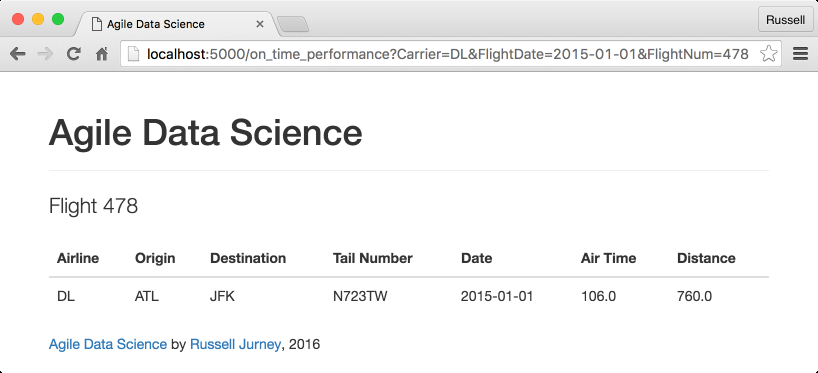

Our Flask console shows the resources being accessed (dates and timestamps removed because of page width constraints):

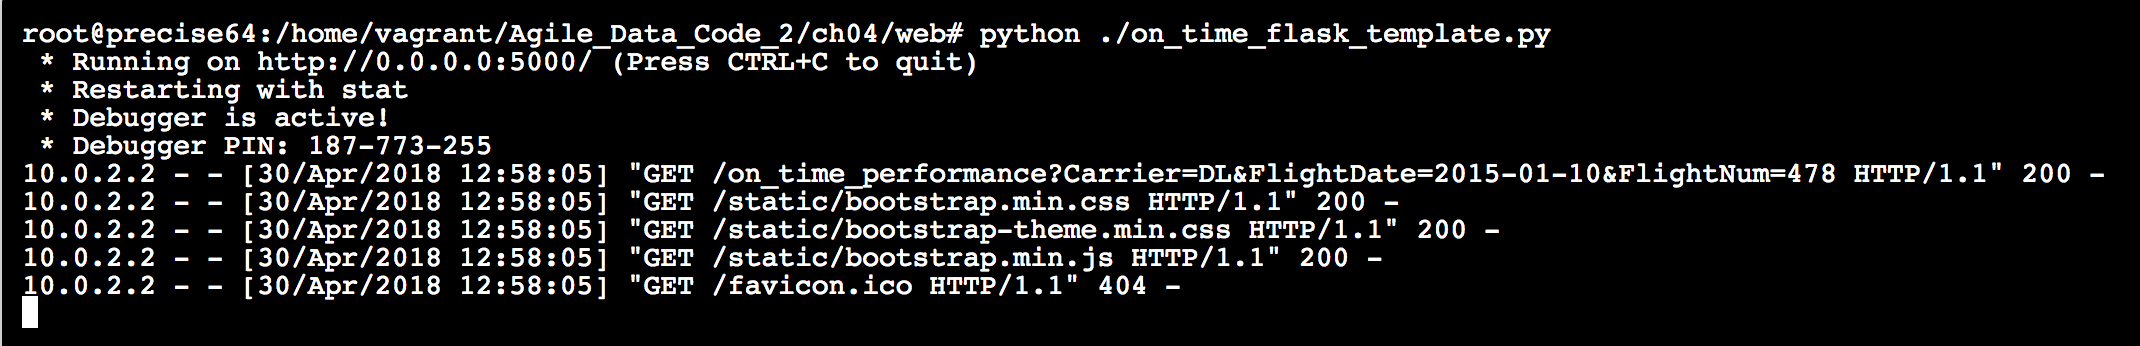


### Our Achievement

Great! We made a web page from raw data! But ... so what? What have we achieved?

We’ve completed the base of the pyramid, level 1—displaying atomic records—in our standard data pipeline. This is a foundation. Whatever advanced analytics we offer, in the end, the user will often want to see the signal itself—that is, the raw data backing our inferences. There is no skipping steps here: if we can’t correctly “visualize” a single atomic record, then our platform and strategy have no base. They are weak.

## Agile Checkpoint

Since we now have working software, it is time to let users in to start getting their feedback. “Wait, really? This thing is embarrassing!” Get over yourself!

We all want to be Steve Jobs; we all want to have a devastating product launch, and to make a huge splash with a top-secret invention. But with analytics applications, when you hesitate to ship, you let your fragile ego undermine your ability to become Steve Jobs by worrying about not looking like him in your first draft. If you don’t ship crap as step 1, you’re unlikely to get to a brilliant step 26. I strongly advise you to learn customer development and apply it to your projects. If you’re in a startup, the Startup Owner’s Manual by Steve Blank (K&S Ranch) is a great place to start.

You will notice immediately when you ship this (maybe to close friends or insiders who clone the source from GitHub at this point) that users can’t find which flights to retrieve by their Carrier, FlightDate, and FlightNum. To get real utility from this data, we need list and search capabilities.

You may well have anticipated this. Why ship something obviously broken or incomplete? Because although step 2 is obvious, step 13 is not. We must involve users at this step because their participation is a fundamental part of completing step 1 of the data-value pyramid. Users provide validation of our underlying assumptions, which at this stage might be stated in the form of two questions: “Does anyone care about flights?” and “What do they want to know about a given flight?” We think we have answers to these questions: “Yes” and “Airline, origin, destination, tail number, date, air time, and distance flown.” But without validation, we don’t really know anything for certain. Without user interaction and learning, we are building in the dark. Success that way is unlikely, just as a pyramid without a strong foundation will soon crumble.

The other reason to ship something now is that the act of publishing, presenting, and sharing your work will highlight a number of problems in your platform setup that would likely otherwise go undiscovered until the moment you launch your product. In Agile Data Science, you always ship after a sprint. As a team member, you don’t control whether to ship or not. You control what to ship and how broad an audience to release it to. This release might be appropriate for five friends and family members, and you might have to hound them to get it running or to click the link. But in sharing your budding application, you will optimize your packaging and resolve dependencies. You’ll have to make it presentable. Without such work, without a clear deliverable to guide your efforts, technical issues you are blinded to by familiarity will be transparent to you.

Now, let’s add listing flights and extend that to enable search, so we can start generating real clicks from real users.



## Listing Flights

Flights are usually presented as a price-sorted list, filtered by the origin and destination, with the cheapest flight first. We lack price data, so instead we’ll list all flights on a given day between two destinations, sorted by departure time as a primary key, and arrival time as a secondary key. A list helps group individual flights with other similar flights. Lists are the next step in building this layer of the data-value pyramid, after displaying individual records.

### Listing Flights with MongoDB

Before we search our flights, we need the capacity to list them in order to display our search results. We can use MongoDB’s query capabilities to return a list of flights between airports on a given day, sorted by departure and arrival time.

In your terminal, run `mongo agile_data_science`.

```javascript
db.on_time_performance.find(
  {
    Origin: 'ATL', 
    Dest: 'SFO', 
    FlightDate: '2015-01-01'
  }).sort({ DepTime: 1, ArrTime: 1 })
```

You may see this error:

```javascript
error: {
    "$err" : "too much data for sort() with no index.  add an index or specify a
              smaller limit",
    "code" : 10128
  }
```

If not, this query may still take a long time to complete, so let’s add another index for it. In general, we’ll need to add an index for each access pattern in our application, so always remember to do so up front in order to save yourself trouble with performance in the future:

```javascript
db.on_time_performance.ensureIndex({ Origin: 1, Dest: 1, FlightDate: 1 })
```

Now we can try our query and find that it is much faster!

```javascript
db.on_time_performance.find(
  {
    Origin: 'ATL', 
    Dest: 'SFO', 
    FlightDate: '2015-01-01'
  }).sort({ DepTime: 1, ArrTime: 1 })
```

Our Flask stub works the same as before—except this time it passes an array of flights instead of one flight. This time, we’re using slugs in the URL for our web controller. A slug puts arguments in between forward slashes, instead of as query parameters.

Note that there is a bit more complexity here to handle pagination, but we'll hold off on explaining this for now. Suffice it to say that you can grab a slice of records - say 0-20, or 20-40, to display on a web page, enabling pagination through multiple pages of records. This helps when a list of records don't fit on a single page.

```python
# Controller: Fetch all flights between cities on a given day and display them
@app.route("/flights/<origin>/<dest>/<flight_date>")
def list_flights(origin, dest, flight_date):
  
  start = request.args.get('start') or 0
  start = int(start)
  end = request.args.get('end') or config.RECORDS_PER_PAGE
  end = int(end)
  width = end - start
  
  nav_offsets = get_navigation_offsets(start, end, config.RECORDS_PER_PAGE)
  
  flights = client.agile_data_science.on_time_performance.find(
    {
      'Origin': origin,
      'Dest': dest,
      'FlightDate': flight_date
    },
    sort = [
      ('DepTime', 1),
      ('ArrTime', 1)
    ]
  )
  flight_count = flights.count()
  flights = flights.skip(start).limit(width)
  
  return render_template(
    'flights.html', 
    flights=flights, 
    flight_date=flight_date, 
    flight_count=flight_count,
    nav_path=request.path,
    nav_offsets=nav_offsets
    )
```

Our templates are pretty simple too, owing to Bootstrap’s snazzy presentation of tables. Tables are often scoffed at by designers when used for layout, but this is tabular data, so their use is appropriate. To be extra snazzy, we’ve included the number of flights that day, and since the date is constant for all records, it is a field in the title of the page instead of a column:

```html
{% extends "layout.html" %}
{% block body %}
  <div>
    <p class="lead">{{flight_count}} Flights on {{flight_date}}</p>
    <table class="table table-condensed table-striped">
      <thead>
        <th>Airline</th>
        <th>Flight Number</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Departure Time</th>
        <th>Tail Number</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        {% for flight in flights %}
        <tr>
          <td>{{flight.Carrier}}</td>
          <td>
<a href="/on_time_performance?Carrier={{flight.Carrier}}&FlightDate={{flight.FlightDate}}&FlightNum={{flight.FlightNum}}">{{flight.FlightNum}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.DepTime}}</td>
          <td>{{flight.TailNum}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
  </div>
{% endblock %}
```

We can bind as many variables to a template as we want. Note that we also link from the list page to the individual record pages, constructing the links out of the airline carrier, flight number, and flight date.

Visit the search page via: [http://localhost:5000/flights/ATL/SFO/2015-01-01](http://localhost:5000/flights/ATL/SFO/2015-01-01)

![ads2_0406.png](attachment:ads2_0406.png)

### Linking Between Entities

Click on the links and in the list of flights to go to the flight's individual page, which we built previously. This linking between entities is a big part of Agile Data Science. 

## Paginating Data

Now that we can list the flights on a given day between cities, our users say, “What if I want to see lots of flights and there are so many on one page that it crashes my browser?” Listing hundreds of records is not a good presentation, and this will happen for other types of data. Shouldn’t there be a previous/next button to scroll forward and back in time? Yes. That is what we’ll add next.

So far we’ve glossed over how we’re creating these templates, subtemplates, and macros. Now we’re going to dive in by creating a macro and a subtemplate for pagination.

### REINVENTING THE WHEEL?

Why are we building our own pagination? Isn’t that a solved problem?

#### Direct Data Connections

The first answer is that it makes a good example to connect the browser with the data directly. In Agile Data Science, we try to process the data into the very state it takes on a user’s screen with minimal manipulation between the backend and an image in a browser. Why? We do this because it decreases complexity in our systems, because it unites data scientists and designers around the same vision, and because this philosophy embraces the nature of distributed systems in that it doesn’t rely on joins or other tricks that work best on “big iron,” or legacy systems.

#### Model and View Consistency

Keeping the model consistent with the view is critical when the model is complex, as in a predictive system. We can best create value when the interaction design around a feature is cognizant of and consistent with the underlying data model. Data scientists must bring understanding of the data to the rest of the team, or the team can’t build to a common vision. The principle of building a view to match the model ensures this from the beginning.

#### Prototyping At Any Level in the Stack

In practice, we cannot predict at which layer a feature will arise. It may first appear as a burst of creativity from a web developer, designer, data scientist, or platform engineer. To validate it, we must ship it in an experiment as quickly as possible, and so the implementation layer of a feature may in fact begin at any level of our stack. When this happens, we must take note and ticket the feature as containing technical debt. As the feature stabilizes, if it is to remain in the system, we move it further back in the stack as time permits.

#### Django or Rails vs Flask or Sinatra

A full-blown application framework like Rails or Django would likely build in this functionality. However, when we are building an application around derived data, the mechanics of interactions often vary in both subtle and dramatic ways. Most web frameworks are optimized around CRUD operations. In big data exploration and visualization, we’re only doing the read part of CRUD, and we’re doing relatively complex visualization as part of it. Frameworks offer less value in this situation, where their behavior must likely be customized. Also note that while MongoDB happens to include the ability to select and return a range of sorted records, the NoSQL store you use may or may not provide this functionality, or it may not be possible to use this feature because publishing your data in a timely manner requires a custom service. You may have to precompute the data periodically and serve the list yourself. NoSQL gives us options, and web frameworks are optimized for relational databases. We must often take matters into our own hands.

## Serving Paginated Data

To start, we’ll need to change our controller for flights to use pagination via MongoDB. There is a little math to do, since MongoDB pagination uses skip and limit instead of start and end. We need to compute the __width__ of the query by subtracting the __start__ from the __end__, then applying this width in a limit call:

```python
# Controller: Fetch all flights between cities on a given day and display them
@app.route("/flights/<origin>/<dest>/<flight_date>")
def list_flights(origin, dest, flight_date):
  
  start = request.args.get('start') or 0
  start = int(start)
  end = request.args.get('end') or config.RECORDS_PER_PAGE
  end = int(end)
  width = end - start
  
  nav_offsets = get_navigation_offsets(start, end, config.RECORDS_PER_PAGE)
  
  flights = client.agile_data_science.on_time_performance.find(
    {
      'Origin': origin,
      'Dest': dest,
      'FlightDate': flight_date
    },
    sort = [
      ('DepTime', 1),
      ('ArrTime', 1)
    ]
  )
  flight_count = flights.count()
  flights = flights.skip(start).limit(width)
    
  return render_template(
    'flights.html', 
    flights=flights, 
    flight_date=flight_date, 
    flight_count=flight_count,
    nav_path=request.path,
    nav_offsets=nav_offsets
  )
```

### Prototyping Back from HTML

In order to implement pagination in our templates, we need to prototype back from HTML. We’re all familiar with next/previous buttons from browsing flights on airline websites. We’ll need to set up the same thing for listing flights. We need links at the bottom of the flight list page below that allow you to paginate forward and back.

More specifically, we need a link to an incremented/decremented offset range for the path `/flights/<origin>/<dest>/<date>?start=N&end=N`. Below we have prototyped the feature based on these requirements by appending static forward and back links against our flight list API.

![ads2_0408.png](attachment:ads2_0408.png)

For example, we want to dynamically render this HTML, corresponding to the URL `/flights/JFK/LAX/2015-01-01?start=20&end=40`:

```html
<div style="text-align: center">
  <a href="/flights/{{origin}}/{{dest}}/{{flight_date}}?start=0&end=20">Previous</a>
  <a href="/flights/{{origin}}/{{dest}}/{{flight_date}}?start=20&end=40">Next</a>
</div>
```

Pasting and navigating to the links, such as [http://localhost:5000/flights/JFK/LAX/2015-01-01?start=20&end=40](http://localhost:5000/flights/JFK/LAX/2015-01-01?start=20&end=40), demonstrates that the feature works with our data.

Now let’s generalize it. Macros are convenient, but we don’t want to make our template too complicated, so we compute the increments in a Python helper (we might consider a model class) and make a macro to render the offsets.

For starters, let’s use this opportunity to set up a simple config file to set variables like the number of records to display per page (embedding these in code will cause headaches later). Check out [ch04/web/config.py](web/config.py).

```python
# config.py, a configuration file for index.py
RECORDS_PER_PAGE=15
ELASTIC_URL='http://localhost:9200/agile_data_science'
```

Let’s also create a simple helper to calculate record offsets. In time this will become a full-blown class model, but for now, we’ll just create a couple of helper methods in [ch04/web/on_time_flask_template.py](web/on_time_flask_template.py):

```python
# Calculate offsets for fetching lists of flights from MongoDB
def get_navigation_offsets(offset1, offset2, increment):
  offsets = {}
  offsets['Next'] = {'top_offset': offset2 + increment, 'bottom_offset': 
  offset1 + increment}
  offsets['Previous'] = {'top_offset': max(offset2 - increment, 0), 
 'bottom_offset': max(offset1 - increment, 0)} # Don't go < 0
  return offsets

# Strip the existing start and end parameters from the query string
def strip_place(url):
  try:
    p = re.match('(.+)&start=.+&end=.+', url).group(1)
  except AttributeError as e:
    return url
  return p
```

Our flight list template, [ch04/web/templates/flights.html](ch04/web/templates/flights.html), calls a macro to render our data. Note the use of `|safe` to ensure our HTML isn’t escaped:

```python
  {% import "macros.jnj" as common %}
  {% if nav_offsets and nav_path -%}
    {{ common.display_nav(nav_offsets, nav_path, flight_count, query)|safe }}
  {% endif -%}
```

We place this in our Jinja2 macros file, further breaking up the task as the drawing of two links inside a div:

```html
<!-- Display two navigation links for previous/next page in the flight list -->;
{% macro display_nav(offsets, path, count, query) -%}
  <div style="text-align: center;">
    {% for key, values in offsets.items() -%}
      {%- if values['bottom_offset'] >= 0 and values['top_offset'] > 0 and count > values['bottom_offset'] -%}
        <a style="margin-left: 20px; margin-right: 20px;" href="{{ path }}?start={{ values ['bottom_offset'] }}&amp;end={{ values['top_offset'] }}{%- if query -%}?search={{query}}{%- endif -%}">{{ key }}</a>
      {% else -%}
        {{ key }}
      {% endif %}
    {% endfor -%}
  </div>
{% endmacro %}
```

And we’re done. We can now paginate through our list of flights as we would in any other flight website. We’re one step closer to providing the kind of user experience that will enable real user sessions, and we’ve extended a graph connecting flights over the top of our individual records. This additional structure will enable even more structure later on, as we climb the data-value pyramid.

Check out the page again at [http://localhost:5000/flights/LAX/JFK/2015-01-10](http://localhost:5000/flights/LAX/JFK/2015-01-10).

## Searching for Flights

Browsing through a list of flights certainly beats manually looking up message_ids, but it’s hardly as efficient as searching for flights of interest. Let’s use our data platform to add search.

### Creating Our Index

Before we can store our documents in Elasticsearch, we need to create a search index for them to reside in. Check out [elastic_scripts/create.sh](../elastic_scripts/create.sh). Note that we create only a single shard with a single replica. In production, you would want to distribute the workload around a cluster of multiple machines with multiple shards, and to achieve redundancy and high availability with multiple replicas of each shard. For our purposes, one of each is fine!

```bash
#!/usr/bin/env bash

curl -XPUT 'http://localhost:9200/agile_data_science/' -d '{
    "settings" : {
        "index" : {
            "number_of_shards" : 1,
            "number_of_replicas" : 1
        }
    }
}'
```

Go ahead and run the script, before we move on to publishing our on-time performance records to Elasticsearch:

```bash
elastic_scripts/create.sh
```

Note that if you want to start over, you can blow away the agile_data_science index with:

```bash
elastic_scripts/drop.sh
```

And just like the create script, it calls curl:

```bash
#!/usr/bin/env bash

curl -XDELETE 'http://localhost:9200/agile_data_science/'
```

## Publishing Flights from PySpark to Elasticsearch

Using the recipe we created in Chapter 2, it is easy to publish our on-time performance flight data to Elasticsearch. Check out [pyspark_to_elasticsearch.py](pyspark_to_elasticsearch.py):

In [9]:
# Load the Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Save the DataFrame to Elasticsearch
on_time_dataframe.write.format("org.elasticsearch.spark.sql")\
  .option("es.resource","agile_data_science/on_time_performance")\
  .option("es.batch.size.entries","100")\
  .mode("overwrite")\
  .save()

print("Records written to Elasticsearch!")

Py4JJavaError: An error occurred while calling o78.save.
: java.lang.NoClassDefFoundError: scala/Product$class
	at org.elasticsearch.spark.sql.ElasticsearchRelation.<init>(DefaultSource.scala:190)
	at org.elasticsearch.spark.sql.DefaultSource.createRelation(DefaultSource.scala:101)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:46)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:86)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:290)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: scala.Product$class
	at java.net.URLClassLoader.findClass(URLClassLoader.java:381)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	... 31 more


_Note that we need to set es.batch.size.entries to 100, down from the default of 1000. This keeps Elasticsearch from being overwhelmed by Spark. You can find other settings to adjust in the configuration guide._

This query might take some time, as there are several million records to index. You might want to leave this alone to run for a while. You can interrupt it midway and move on; so long as some records are indexed you should be okay. Similarly, if there is an error, you should check the results of the following query; it might be possible to disregard the error and just move on, if enough records have been indexed for the rest of the examples.

Querying our data with curl is easy. This time, let’s look for flights originating in Atlanta (airport code ATL), the world’s busiest airport:

In [ ]:
%%bash

curl 'http://localhost:9200/agile_data_science/on_time_performance/_search?q=Origin:ATL&pretty'

Note the useful information our query returned along with the records found: how long the query took (7 ms) and the total number of records that matched our query ().

## Searching Flights on the Web

Next, let’s connect our search engine to the web. First, configure `pyelastic` to point at our Elasticsearch server:

```python
# ch04/web/config.py
ELASTIC_URL = 'http://localhost:9200/agile_data_science'
```

Then import, set up, and query Elasticsearch via the `/flights/search` path in [ch04/web/on_time_flask_template.py](web/on_time_flask_template.py):

```python
@app.route("/flights/search")
@app.route("/flights/search/")
def search_flights():
  
  # Search parameters
  carrier = request.args.get('Carrier')
  flight_date = request.args.get('FlightDate')
  origin = request.args.get('Origin')
  dest = request.args.get('Dest')
  tail_number = request.args.get('TailNum')
  flight_number = request.args.get('FlightNum')
  
  # Pagination parameters
  start = request.args.get('start') or 0
  start = int(start)
  end = request.args.get('end') or config.RECORDS_PER_PAGE
  end = int(end)
  
  print(request.args)
  # Navigation path and offset setup
  nav_path = strip_place(request.url)
  nav_offsets = get_navigation_offsets(start, end, config.RECORDS_PER_PAGE)
  
  # Build the base of our elasticsearch query
  query = {
    'query': {
      'bool': {
        'must': []}
    },
    'sort': [
      {'FlightDate': {'order': 'asc'} },
      '_score'
    ],
    'from': start,
    'size': config.RECORDS_PER_PAGE
  }
  
  # Add any search parameters present
  if carrier:
    query['query']['bool']['must'].append({'match': {'Carrier': carrier}})
  if flight_date:
    query['query']['bool']['must'].append({'match': {'FlightDate': flight_date}})
  if origin: 
    query['query']['bool']['must'].append({'match': {'Origin': origin}})
  if dest: 
    query['query']['bool']['must'].append({'match': {'Dest': dest}})
  if tail_number: 
    query['query']['bool']['must'].append({'match': {'TailNum': tail_number}})
  if flight_number: 
    query['query']['bool']['must'].append({'match': {'FlightNum': flight_number}})
  
  # Query elasticsearch, process to get records and count
  results = elastic.search(query)
  flights, flight_count = process_search(results)
  
  # Persist search parameters in the form template
  return render_template(
    'search.html', 
    flights=flights, 
    flight_date=flight_date, 
    flight_count=flight_count,
    nav_path=nav_path,
    nav_offsets=nav_offsets,
    carrier=carrier,
    origin=origin,
    dest=dest,
    tail_number=tail_number,
    flight_number=flight_number
    )
 ```
 
 
Generalizing the navigation links, we are able to use a similar template for searching flights as we did for listing them. We’ll need a form to search for flights against specific fields, so we create one at the top of the page. We have parameterized the template with all of our search arguments, to persist them through multiple submissions of the form. Check out [ch04/web/templates/search.html](web/templates/search.html):

```html
<form action="/flights/search" method="get">
  <label for="Carrier">Carrier</label>
  <input name="Carrier" maxlength="3" style="width: 40px; margin-right: 10px;" 
      value="{{carrier}}"></input>
  <label for="Origin">Origin</label>
  <input name="Origin" maxlength="3" style="width: 40px; margin-right: 10px;" 
      value="{{origin}}"></input>
  <label for="Dest">Dest</label>
  <input name="Dest" maxlength="3" style="width: 40px; margin-right: 10px;" 
      value="{{dest}}"></input>
  <label for="FlightDate">FlightDate</label>
  <input name="FlightDate" style="width: 100px; margin-right: 10px;" 
      value="{{flight_date}}"></input>
  <label for="TailNum">TailNum</label>
  <input name="TailNum" style="width: 100px; margin-right: 10px;" 
      value="{{tail_number}}"></input>
  <label for="FlightNum">FlightNum</label>
  <input name="FlightNum" style="width: 50px; margin-right: 10px;" 
      value="{{flight_number}}"></input>
  <button type="submit" class="btn btn-xs btn-default" style="height: 25px">
   Submit
  </button>
</form>
```

![ads2_0409.png](attachment:ads2_0409.png)

### Visiting Our Search Page

You can view the results at [http://localhost:5000/flights/search](http://localhost:5000/flights/search). Fill in the form with an airline code - `DL` for Delta, `AA` for American, etc and a date in ISO format - `2015-01-01` for example, submit the form and see the resulting flights that come up.

## Conclusion

We have now collected, published, indexed, displayed, listed, and searched flight records. They are no longer abstract. We can search for flights, click on individual flights, and explore as we might any other dataset. More importantly, we have piped our raw data through our platform and transformed it into an interactive application.

This application forms the base of our value stack. We will use it as the way to develop, present, and iterate on more advanced features throughout the book as we build value while walking up the data-value pyramid. With the base of the pyramid in place, we can move on to building charts.